In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras.layers as L
import tensorflow_addons as tfa
import glob, random, os, warnings
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

print('TensorFlow Version ' + tf.__version__)

def seed_everything(seed = 0):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

seed_everything()

import warnings
warnings.filterwarnings("ignore")


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


TensorFlow Version 2.12.0


In [2]:
pip install vit-keras

Note: you may need to restart the kernel to use updated packages.


In [3]:
from vit_keras import vit, utils

In [4]:
image_size = 224
batch_size = 16
n_classes = 7
EPOCHS = 48

train_path = '/kaggle/input/brain-tumor'
testsplit = 0.5
classes =['angry','disgust','fear','happy','neutral','sad','surprise']
classes ={i+1:x for i,x in enumerate(classes)}


data_dir = "/kaggle/input/raf-db-dataset/DATASET/train/"
data_dir1 = "/kaggle/input/raf-db-dataset/DATASET/test/"

In [5]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rescale=1./255,
        brightness_range=[0.9,1.1],
        horizontal_flip=True,
        fill_mode='nearest',
        preprocessing_function=vit.preprocess_inputs
)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rescale=1./255,
        validation_split=testsplit,
        preprocessing_function=vit.preprocess_inputs
)


# set as training data

train_gen  = train_datagen.flow_from_directory(
    data_dir,
    target_size=(image_size, image_size),
    batch_size = batch_size,
    seed = 1,
    color_mode = 'rgb',
    shuffle = True,
    class_mode='categorical',
    subset='training') 

# same directory as training data

valid_gen  = test_datagen.flow_from_directory(
    data_dir1,
    target_size=(image_size, image_size),
    batch_size = batch_size,
    seed = 1,
    color_mode = 'rgb',
    shuffle = False,
    class_mode='categorical',
    subset='validation')


Found 12271 images belonging to 7 classes.
Found 1533 images belonging to 7 classes.


/kaggle/input/raf-db-dataset/DATASET/train/4/train_00881_aligned.jpg


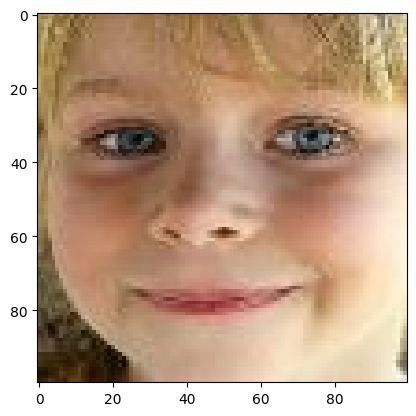

In [6]:
import matplotlib.image as mpimg

img = train_gen.filepaths[np.random.random_integers(low=0, high=train_gen.samples)]
print(img)
img = mpimg.imread(img)
plt.imshow(img)

In [7]:
vit_model = vit.vit_b16(
        image_size = image_size,
        activation = 'softmax',
        pretrained = True,
        include_top = False,
        pretrained_top = False,
        classes = 7)
model = tf.keras.Sequential([
        vit_model,
        tf.keras.layers.Flatten(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(128, activation = tfa.activations.gelu),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(64, activation = tfa.activations.gelu),
        tf.keras.layers.Dense(32, activation = tfa.activations.gelu),
        tf.keras.layers.Dense(7, 'softmax')
    ],
    name = 'vision_transformer')

model.summary()

Model: "vision_transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vit-b16 (Functional)        (None, 768)               85798656  
                                                                 
 flatten (Flatten)           (None, 768)               0         
                                                                 
 batch_normalization (BatchN  (None, 768)              3072      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 128)               98432     
                                                                 
 batch_normalization_1 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                                 
 dense_1 (Dense)             (None, 64)         

In [8]:
warnings.filterwarnings("ignore")

learning_rate = 1e-4

optimizer = tfa.optimizers.RectifiedAdam(learning_rate = learning_rate)

model.compile(optimizer = optimizer, 
              loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing = 0.2), 
              metrics = ['accuracy'])

STEP_SIZE_TRAIN = train_gen.n // train_gen.batch_size
STEP_SIZE_VALID = valid_gen.n // valid_gen.batch_size



early_stopping_callbacks = tf.keras.callbacks.EarlyStopping(patience = 15, restore_best_weights = True, verbose = 1)

model_history= model.fit(x = train_gen,
          steps_per_epoch = STEP_SIZE_TRAIN,
          validation_data = valid_gen,
          validation_steps = STEP_SIZE_VALID,
          epochs = EPOCHS,
          callbacks = early_stopping_callbacks)


Epoch 1/48
766/766 [==============================] - 425s 510ms/step - loss: 1.9860 - accuracy: 0.2091 - val_loss: 1.8571 - val_accuracy: 0.3895
Epoch 2/48
766/766 [==============================] - 385s 503ms/step - loss: 1.8536 - accuracy: 0.3155 - val_loss: 1.8663 - val_accuracy: 0.2151
Epoch 3/48
766/766 [==============================] - 387s 506ms/step - loss: 1.8104 - accuracy: 0.3533 - val_loss: 1.8206 - val_accuracy: 0.3895
Epoch 4/48
766/766 [==============================] - 385s 503ms/step - loss: 1.7962 - accuracy: 0.3724 - val_loss: 1.8392 - val_accuracy: 0.1572
Epoch 5/48
766/766 [==============================] - 381s 497ms/step - loss: 1.7888 - accuracy: 0.3766 - val_loss: 1.8986 - val_accuracy: 0.3895
Epoch 6/48
766/766 [==============================] - 388s 506ms/step - loss: 1.7819 - accuracy: 0.3798 - val_loss: 1.7746 - val_accuracy: 0.3895
Epoch 7/48
766/766 [==============================] - 381s 498ms/step - loss: 1.7755 - accuracy: 0.3834 - val_loss: 1.7517 -

In [9]:
history = pd.DataFrame(model_history.history)
history.to_csv('DenseNet121.csv', index=False)
history

,loss,accuracy,val_loss,val_accuracy
0,1.985954,0.209058,1.857124,0.389474
1,1.853565,0.315463,1.866254,0.215132
2,1.810429,0.353325,1.820643,0.389474
3,1.796159,0.372419,1.839153,0.157237
4,1.788849,0.376581,1.898571,0.389474
5,1.781917,0.379763,1.774566,0.389474
6,1.775452,0.383435,1.751736,0.389474
7,1.771249,0.387434,1.750958,0.389474
8,1.757889,0.392738,1.668411,0.436842
9,1.642003,0.462668,1.598874,0.495395


<h2>Plotting<h2>

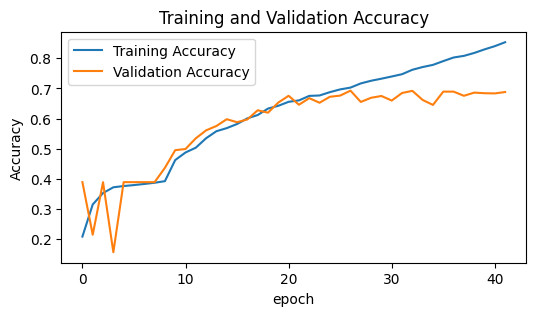

In [10]:
f, ax=plt.subplots(figsize=(6,3))
plt.plot(model_history.history['accuracy'], label='Training Accuracy')
plt.plot(model_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend()
plt.show()

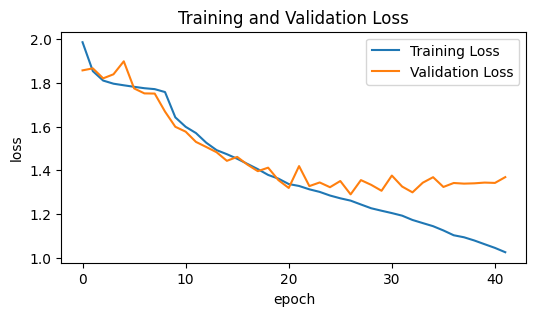

In [11]:
f, ax=plt.subplots(figsize=(6,3))
plt.plot(model_history.history['loss'], label='Training Loss')
plt.plot(model_history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

<h2>Model Evaluation<h2>

In [13]:
valid_gen.reset()
predictions = model.predict_generator(valid_gen, steps=len(valid_gen))
y = np.argmax(predictions, axis=1)

print('Classification Report')
cr = classification_report(y_true=valid_gen.classes, y_pred=y, target_names=valid_gen.class_indices)
print(cr)

Classification Report
              precision    recall  f1-score   support

           1       0.62      0.63      0.62       164
           2       0.36      0.22      0.27        37
           3       0.46      0.33      0.38        80
           4       0.84      0.89      0.86       592
           5       0.58      0.51      0.54       239
           6       0.45      0.52      0.48        81
           7       0.66      0.69      0.68       340

    accuracy                           0.69      1533
   macro avg       0.57      0.54      0.55      1533
weighted avg       0.68      0.69      0.69      1533



In [16]:
#confusion matrixy
y_true=valid_gen.classes


from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_true,y)
cm

array([[103,   5,   2,  13,   8,  10,  23],
       [  9,   8,   2,   9,   1,   3,   5],
       [  2,   1,  26,   8,  14,  11,  18],
       [  5,   4,   6, 528,  20,  10,  19],
       [ 11,   3,   8,  39, 121,  12,  45],
       [  4,   0,   6,  10,  10,  42,   9],
       [ 32,   1,   6,  25,  36,   6, 234]])

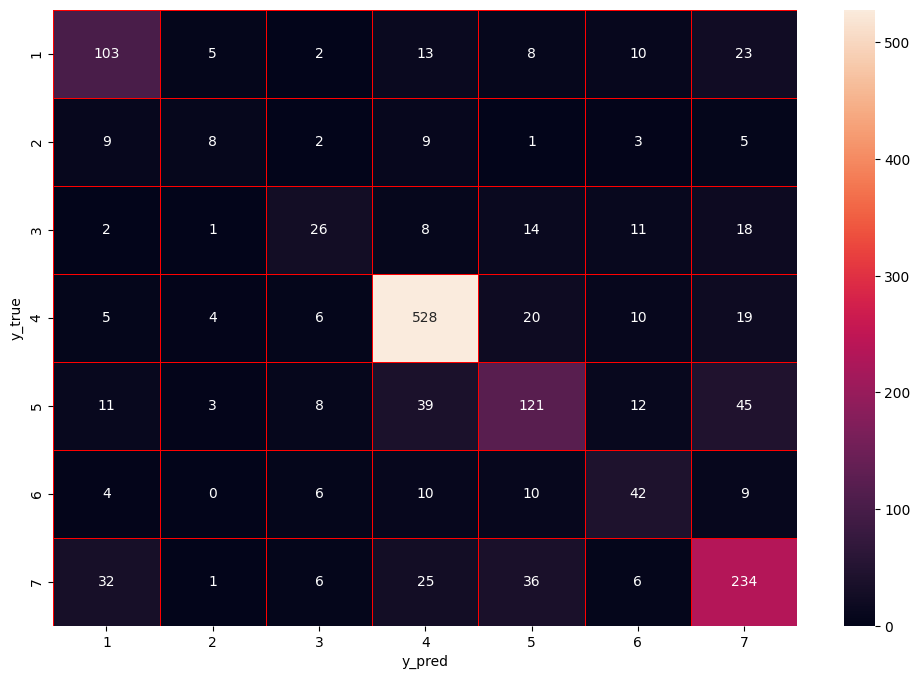

In [18]:
f, ax=plt.subplots(figsize=(12,8))
sns.heatmap(cm,annot=True,linewidths=0.5,linecolor="red",fmt=".0f",ax=ax,xticklabels=classes, yticklabels=classes,)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.savefig('confusion_matrix.png', transparent=False, dpi=500)
plt.show()

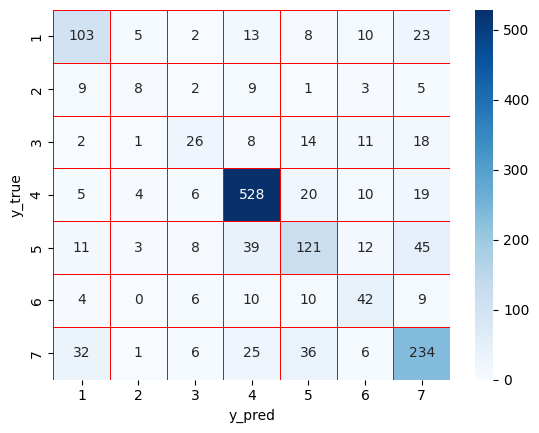

In [20]:
sns.heatmap(cm,cmap="Blues",annot=True,linewidths=0.5,linecolor="red",fmt=".0f",xticklabels=classes, yticklabels=classes,)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.savefig('confusion_matrix2.png', transparent=False, dpi=500)
plt.show()

In [21]:
model.evaluate(valid_gen , verbose = 1)

96/96 [==============================] - 17s 175ms/step - loss: 1.2907 - accuracy: 0.6928


[1.2906949520111084, 0.6927592754364014]

In [ ]:
#Test the model
model = load_model('/kaggle/working/DenseNet121.h5')

test_image='/kaggle/input/raf-db-dataset/DATASET/test/4/test_0003_aligned.jpg'
image_result=Image.open(test_image)

from tensorflow.keras.preprocessing import image
test_image=image.load_img(test_image,target_size=(targetx, targety))
test_image=image.img_to_array(test_image)
test_image=test_image/255
test_image=np.expand_dims(test_image,axis=0)

result=model.predict(test_image)
print(np.argmax(result))
Categories =target_names
image_result=plt.imshow(image_result)
plt.title(Categories[np.argmax(result)])
plt.show()